In [1]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "neuronal-sequence-test"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from scipy.stats import mannwhitneyu, binom
rstest_twosided = lambda x, y : mannwhitneyu(x, y, alternative='two-sided')

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.plots_pca as plots_pca
from src.lib.metric_wrapper import metric_by_interval, metric_by_phase
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import cluster_dist_matrix



%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/neuronal-sequence-test


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 1. Neuron-Time-Average

**Goal**: Attempt to predict L/R and C/M from mean activity over trial

No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping


,mouse,L,R,nTrials,pval
0,m060,0.074680,0.071550,"(79, 74)",0.228986
1,m061,0.111736,0.110499,"(45, 45)",0.796229
2,m065,0.121804,0.124793,"(122, 116)",0.141527
3,m066,0.137192,0.133464,"(86, 102)",0.318872
4,m067,0.116529,0.116019,"(90, 107)",0.867506
5,m068,0.081292,0.083273,"(126, 112)",0.280199


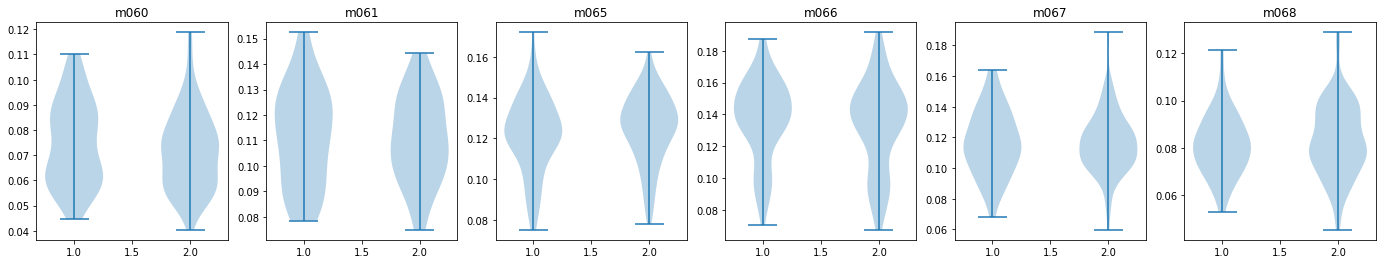

In [7]:
def test_mean_time_and_neurons(dataDB, datatype, selector, condition):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    testResults = []
    
    if "phase" in selector.keys():
        metric_func = lambda queryDict : metric_by_phase(dataDB, queryDict, "mean", "r", {}, phases=[selector["phase"]])[0]
    elif "interval" in selector.keys():
        metric_func = lambda queryDict : metric_by_interval(dataDB, queryDict, "mean", "r", {}, intervals=[selector["interval"]])[0]
    
    fig, ax = plt.subplots(ncols=nMice, figsize=(4*nMice, 4))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:        
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_func(queryDictCond)]

        testResults += [[mousename, *[np.mean(mu) for mu in means], tuple(len(mu) for mu in means), rstest_twosided(*means)[1]]]
        ax[iMouse].violinplot(means)
        ax[iMouse].set_title(mousename)
        
    display(pd.DataFrame(testResults, columns=["mouse", *condValues, "nTrials", "pval"]))
    plt.show()
    
    
test_mean_time_and_neurons(dataDB, "deconv", {"phase" : "Maintenance"}, "direction")
#test_mean_time_and_neurons(dataDB, "raw", {"interval" : 8}, "performance")

# 2 Time-Average

**Goal**: Attempt to predict LR/CM from average activities of individual cells.
* Count predictive cells in each mouse, phase/interval

No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,88,0.0
1,m061,0,46,0.0
2,m065,3,83,1.3
3,m066,0,47,-0.0
4,m067,0,49,0.0
5,m068,1,28,0.6


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


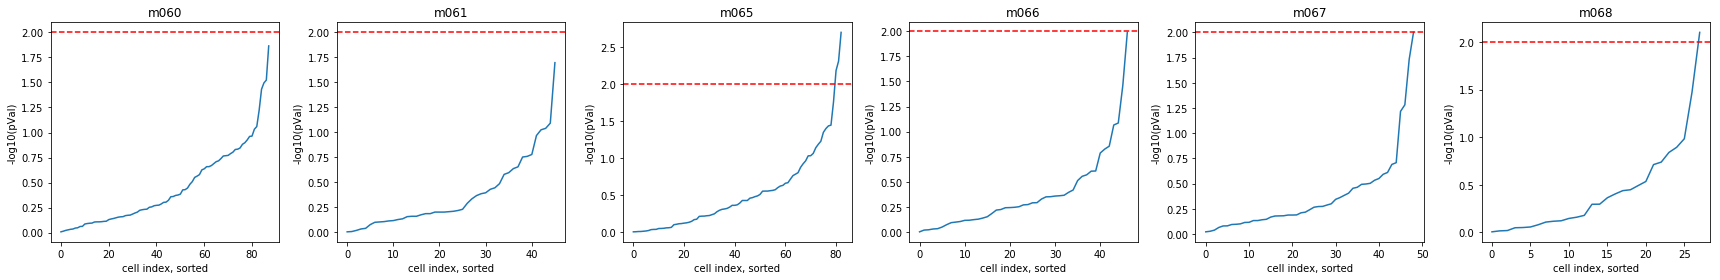

In [70]:
def test_mean_time(dataDB, datatype, selector, condition, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    if "phase" in selector.keys():
        metric_func = lambda queryDict : metric_by_phase(dataDB, queryDict, "mean", "rp", {}, phases=[selector["phase"]])[0]
    elif "interval" in selector.keys():
        metric_func = lambda queryDict : metric_by_interval(dataDB, queryDict, "mean", "rp", {}, intervals=[selector["interval"]])[0]
    
    
    fig1, ax1 = plt.subplots(ncols=nMice, figsize=(4*nMice, 4), tight_layout=True)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:        
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_func(queryDictCond)]
            
        nCells = means[0].shape[1]
        pValByCell = [rstest_twosided(means[0][:, iCell], means[1][:, iCell])[1] for iCell in range(nCells)]

        ax1[iMouse].plot(sorted(-np.log10(pValByCell)))
        ax1[iMouse].axhline(y=2, linestyle="--", color='r')
        ax1[iMouse].set_xlabel("cell index, sorted")
        ax1[iMouse].set_ylabel("-log10(pVal)")
        ax1[iMouse].set_title(mousename)
        
        binomPMF = binom.pmf(np.arange(0, nCells), nCells, pval)
        nCellSignificant = np.sum(np.array(pValByCell) < pval)
        pValPop = np.sum(binomPMF[nCellSignificant:])
        negLogPValPop = np.round(-np.log10(pValPop), 1)
        
        mouseResults += [[mousename, nCellSignificant, nCells, negLogPValPop]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "pvalPopulation"]))
        
    plt.show()
    
#test_mean_time(dataDB, "deconv", {"interval" : 4}, "performance")
test_mean_time(dataDB, "deconv", {"phase" : "Maintenance"}, "direction")

Calculating mouse m060
Calculating mouse m061
Calculating mouse m065
Calculating mouse m066
Calculating mouse m067
Calculating mouse m068


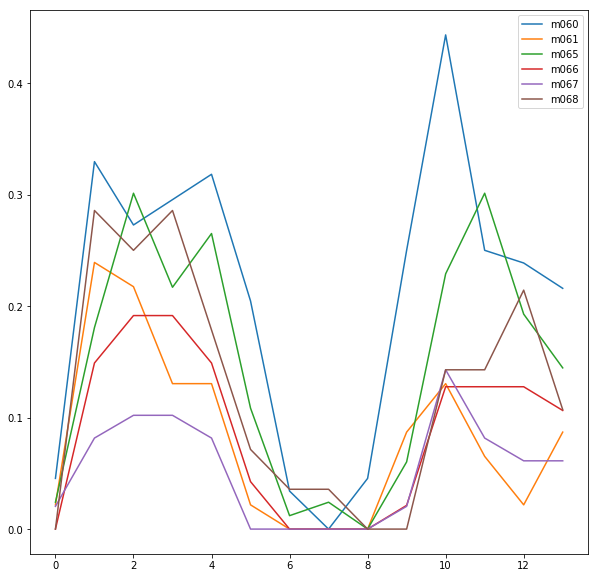

In [78]:
def test_ncells_by_interval(dataDB, datatype, condition, intervRange, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig, ax = plt.subplots(figsize=(10,10))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Calculating mouse", mousename)
        
        freqCellSignificant = []
        for iInterv in intervRange:
        
            means = []
            for condVal in condValues:        
                queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
                means += [
                    metric_by_interval(dataDB, queryDictCond, "mean", "rp", {}, intervals=[iInterv])[0]
                ]

            nCells = means[0].shape[1]
            pValByCell = [rstest_twosided(means[0][:, iCell], means[1][:, iCell])[1] for iCell in range(nCells)]
            nCellSignificant = np.sum(np.array(pValByCell) < pval)
            freqCellSignificant += [nCellSignificant / nCells]
            
        ax.plot(intervRange, freqCellSignificant, label=mousename)

    plt.legend()
    plt.show()
    
test_ncells_by_interval(dataDB, "deconv", "direction", range(0, 14))

# 3. Scalar metric tests

**Goal**: Evaluate predictive power for several metrics
* Stretch hypothesis: Legendre Basis (try several bases individually up to 6)
* Synchronization hypothesis: AvgCorr, H

## Table [TODO]

In [9]:
%%time
dataDB.verbose = False

#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}  # {"metricSettings" : None, "sweepSettings" : None, "zscoreChannel" : None}
settings = {"serial" : True, "zscoreChannel" : False, "metricSettings" :{"max_lag" : 1}}
sweepDict = {
    "datatype": ["raw", "high", "deconv"],
    "performance": ["Correct", "Mistake", "All"],
#    "direction": ["L", "R", "All"]
}

plots_lib.table_discriminate_behavior(dataDB, {"phase" : "Maintenance"}, "direction",
                                      sweepDict,
                                      "mean",
                                      trgDimOrder="r",
                                      settings=settings, multiplexKey="session")

,datatype,performance,L,R,"-logp(0, 1)",nTrial
0,raw,Correct,0.019289,0.950768,1.14,"[[434, 434]]"
1,raw,Mistake,-1.430908,0.520415,1.36,"[[114, 122]]"
2,raw,All,-0.282395,0.856338,1.74,"[[548, 556]]"
3,high,Correct,-0.017412,-0.018896,0.35,"[[434, 434]]"
4,high,Mistake,-0.033758,-0.010321,2.22,"[[114, 122]]"
5,high,All,-0.020813,-0.017014,0.83,"[[548, 556]]"
6,deconv,Correct,0.106712,0.108861,0.90,"[[434, 434]]"
7,deconv,Mistake,0.105299,0.105341,0.33,"[[114, 122]]"
8,deconv,All,0.106418,0.108088,0.83,"[[548, 556]]"


CPU times: user 2.58 s, sys: 3.11 ms, total: 2.58 s
Wall time: 2.58 s


## Violins

No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
For ('Mistake', 'Correct') of data size (114, 434) rank-sum-test is 0.0007104739231471268


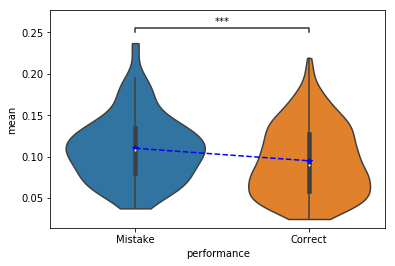

In [69]:
def binary_test_phase(dataDB, queryDict, condition, selector, metricName, settings):
    condValues = list(set(dataDB.metaDataFrames['behaviorStates'][condition]))
    
    if "phase" in selector.keys():
        metric_func = lambda queryDict : metric_by_phase(dataDB, queryDict, metricName, "r", {}, phases=[selector["phase"]])[0]
    elif "interval" in selector.keys():
        metric_func = lambda queryDict : metric_by_interval(dataDB, queryDict, metricName, "r", {}, intervals=[selector["interval"]])[0]
    
    rezLst = []
    for condVal in condValues:
        queryThis = queryDict.copy()
        queryThis[condition] = condVal
        rezLst += [metric_func(queryThis)]
        
    fig, ax = plt.subplots()
    plots_lib.plot_labeled_violins(ax, rezLst, condValues, condition, metricName,
                                   joinMeans=True, haveLog=False, sigTestPairs=[(0,1)])
    
    
settings = {"serial" : True, "metricSettings" : {"metric" : num_sample}}
queryDict = {"datatype" : "deconv", "direction" : "L"}

binary_test_phase(dataDB, queryDict, "performance", {"interval" : 8}, "mean", settings)
#binary_test_phase(dataDB, queryDict, "direction", ["L", "R"], "Maintenance", settings)

# 4. Binary Classification

**Goal**: Train a classifier to discriminate between two cases (L/R), (C/M)

**Versions**:
* **4A. Mouse-wise**: Choose metric that is independent of number of samples, calc individually for each mouse
* **4B. All-mice**: Choose metric that has fixed shape per trial, calc for all mice

**Advantages**:
* Can theoretically make use of vector metrics, by studying their combinations

**Problems**:
* High overfitting. Performance for train and test dramatically different.

**TODO**:
* Research further into regularization. Try more sophisticated estimators (e.g. )
* Impl classification by phase

In [3]:
# 4B
queryDict = {"direction": "L", "datatype": "raw"}
#queryDict = {"performance": "Correct", "datatype": "raw"}
settings = {"zscoreChannel": True, "serial": True, "metricSettings": None}
#settings = {"zscoreChannel": False, "serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

rez = plots_lib.table_binary_classification(dataDB, "Maintenance", "performance", "cumul_ord_coeff", "",
                                            queryDict, settings, multiplexKey="mousekey")

rez

NameError: name 'plots_lib' is not defined

In [ ]:
# 4A
queryDict = {"performance": "Correct", "datatype": "raw"}
#queryDict = {"direction": "L", "datatype": "high"}
settings = {"zscoreChannel": False, "serial": True, "metricSettings": {"lag" : 1, "max_lag" : 3}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

plots_lib.table_binary_classification_bymouse(dataDB, "Maintenance", "direction", "temporal_basis", "rp",
                                              queryDict, settings)

# 5. Trajectory via PCA

1. Construct PCA for all trials of one mouse
2. Plot PCA1 vs PCA2 for 4 conditions

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


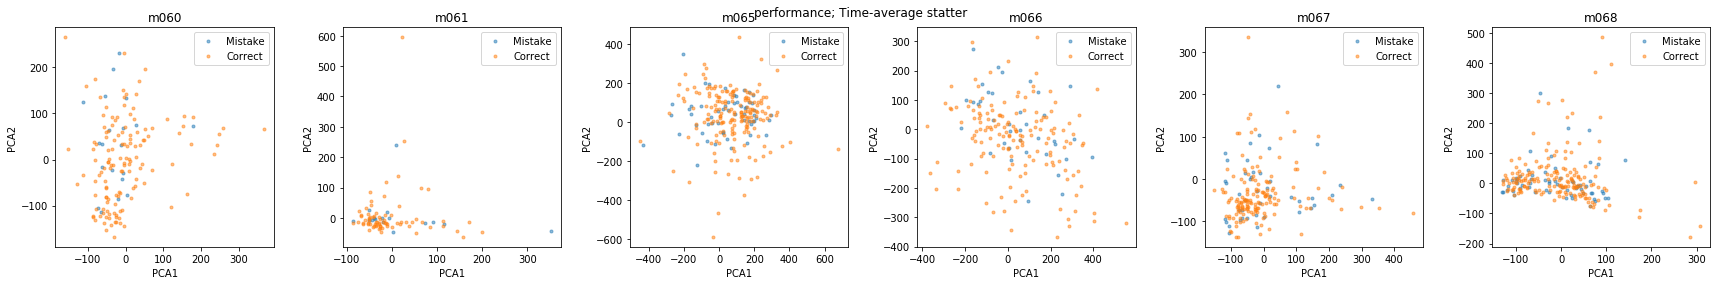

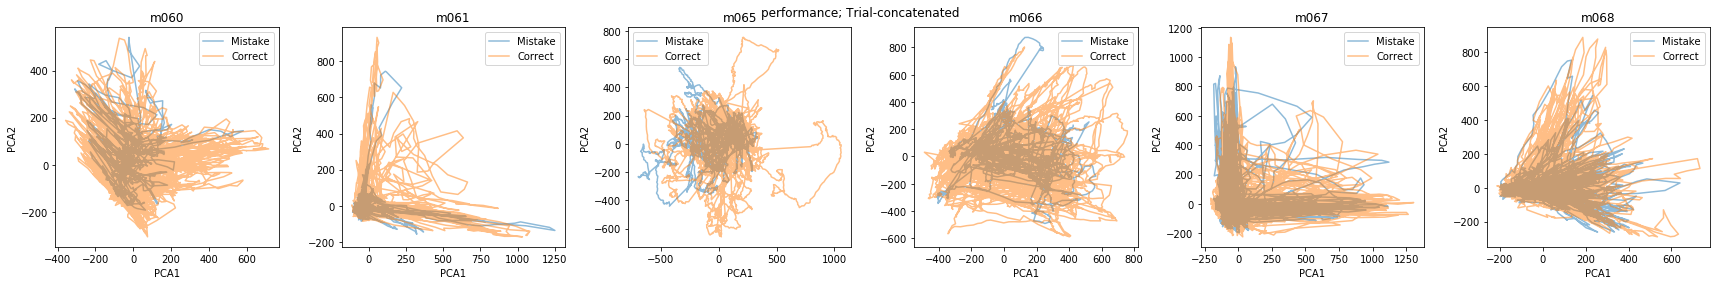

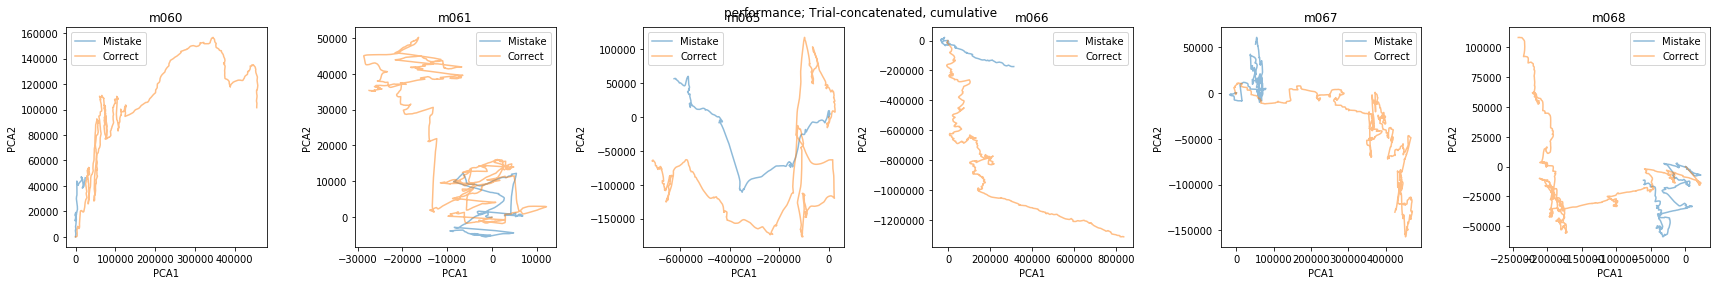

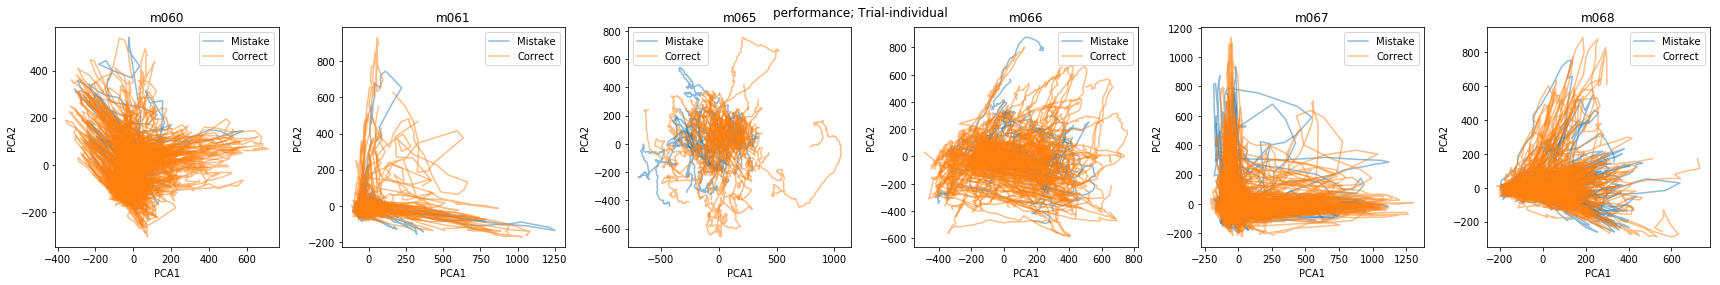

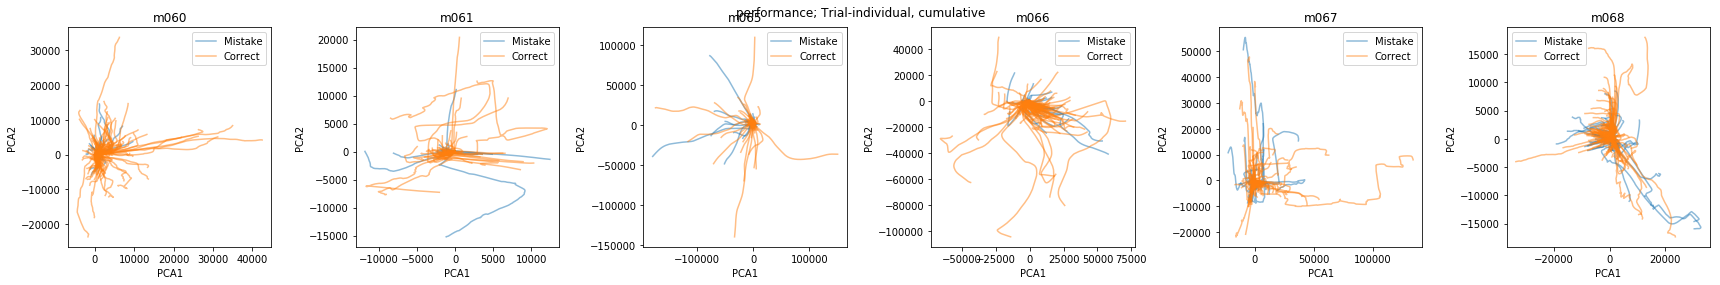

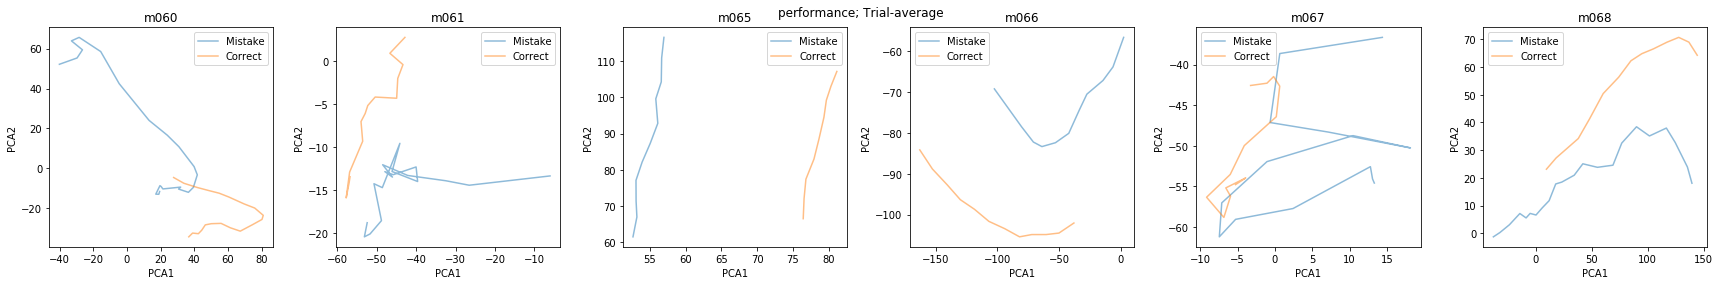

In [79]:
# selector = {"phase" : "Maintenance"}
selector = {"interval" : 6}
#queryDict = {"performance" : "Correct"}
queryDict = {}
#condition = "direction"
condition = "performance"

plotTypeDict = {
    "Time-average statter"           : plots_pca._plot_time_avg_scatter,
    "Trial-concatenated"             : plots_pca._plot_pca_concat,
    "Trial-concatenated, cumulative" : plots_pca._plot_pca_concat_cumul,
    "Trial-individual"               : plots_pca._plot_pca_bytrial,
    "Trial-individual, cumulative"   : plots_pca._plot_pca_bytrial_cumul,
    "Trial-average"                  : plots_pca._plot_pca_time_trial_avg
}

for plotName, plot_func in plotTypeDict.items():
    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 4), tight_layout=True)
    fig.suptitle(condition + "; " + plotName)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        queryDict["mousename"] = mousename
        ax[iMouse].set_title(mousename)
        plots_pca.plot_pca(ax[iMouse], dataDB, selector, queryDict, condition, plot_func=plot_func)
        
plt.show()